<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [293]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np
import os
import torch
from torchvision.datasets import DatasetFolder, ImageFolder


## GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [ ]:
# SEED
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False     

set_seed(42)

In [295]:
file_paths = glob.glob('carpet/*/*/*.png')
file_paths = sorted([path for path in file_paths if path.split("\\")[-1] in [f'{i:03}.png' for i in range(10)]])

In [296]:
all_data = []

for img in tqdm(file_paths):
    img = cv2.imread(img)
    img = img[..., ::-1]
    all_data.append(img)

all_data = np.stack(all_data)
print(all_data.shape)

100%|██████████| 70/70 [00:01<00:00, 56.33it/s]


(70, 1024, 1024, 3)


Classes: ['color', 'cut', 'good', 'hole', 'metal_contamination', 'thread']


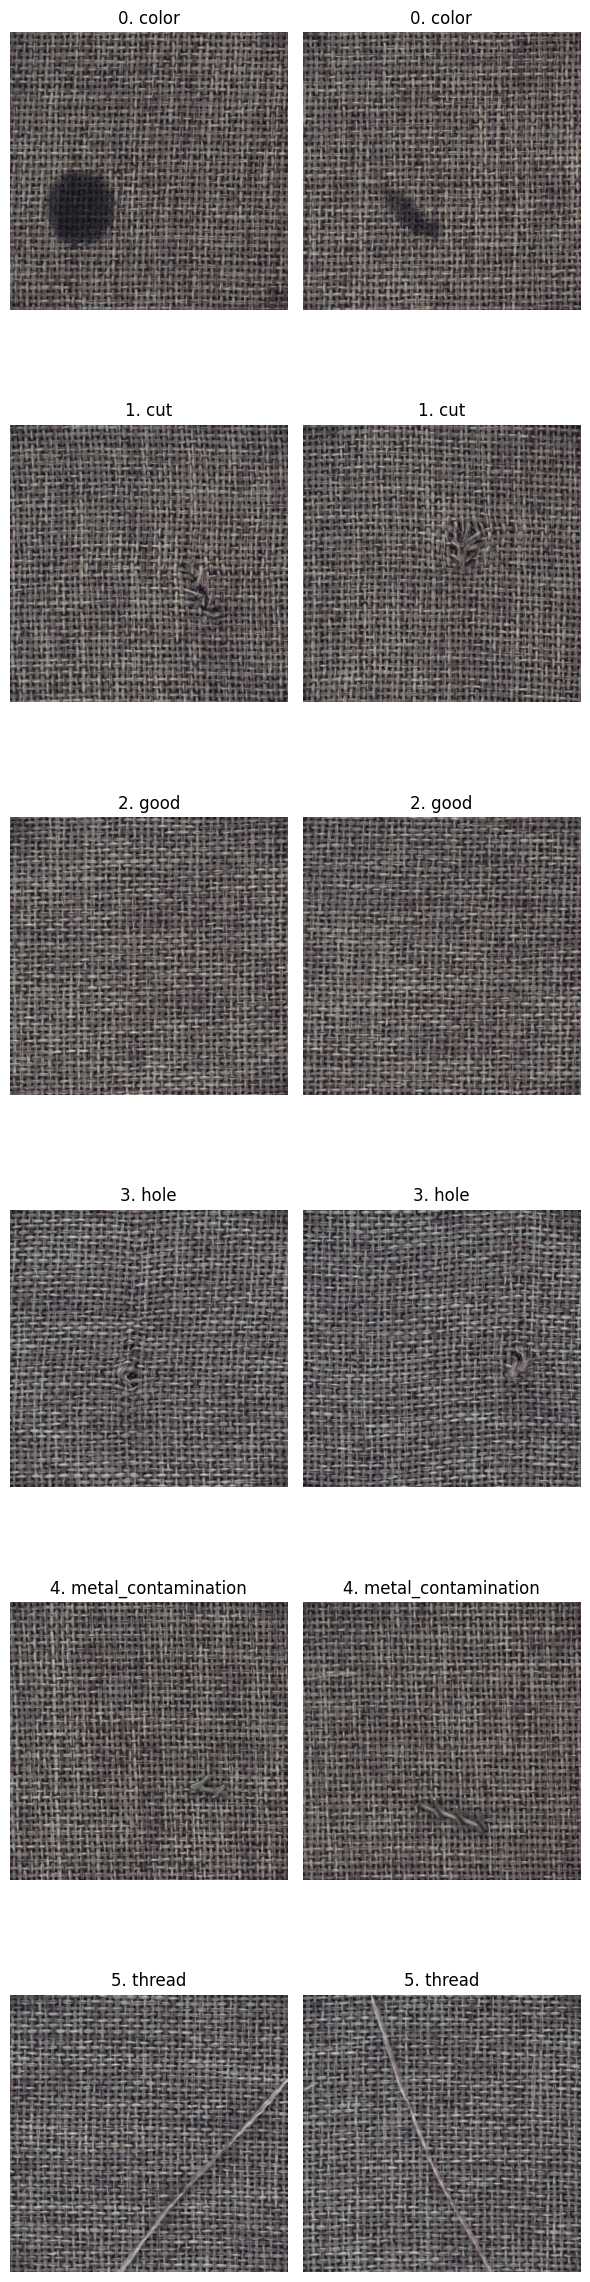

In [297]:
import matplotlib.pyplot as plt
import numpy as np


## There are 5 types of defects: color, cut, hole, metal_contamination, thread
classes = sorted(set([path.split('\\')[2] for path in file_paths]))
print(f'Classes: {classes}')

images_per_class = len(all_data) // len(classes)
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))

for i, class_name in enumerate(classes):
    index = i * images_per_class
    for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

## A. Data Loading and Preprocessing

In [298]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

In [299]:
from sklearn.model_selection import train_test_split

def num_of_pictures_in_one_class(N, full_dataset):
    
    class_count = {}
    selected_indices = []

    # 遍歷所有資料，收集每類前 N 張
    for idx, (path, label) in enumerate(full_dataset.samples):
        if label not in class_count:
            class_count[label] = 0

        if class_count[label] < N:
            selected_indices.append(idx)
            class_count[label] += 1

    # 建立子集
    subset_dataset = Subset(full_dataset, selected_indices)

    return subset_dataset



batch_size = 32 # batch size
images_per_class = 20 #每一個類別 image 上限


# 圖片所在路徑
data_dir = './data'

# train 跟 valid 的圖片是一樣的，但 valid 沒有做 augmentation
train_set = ImageFolder(root=data_dir, transform = train_transforms)
train_set = num_of_pictures_in_one_class(images_per_class, train_set)

valid_set = ImageFolder(root=data_dir, transform = val_transforms)
train_set = num_of_pictures_in_one_class(images_per_class, valid_set)


targets = [train_set.dataset.targets[i] for i in train_set.indices]

## 進行資料切分

train_idx, valid_idx = train_test_split(np.arange(len(targets)), test_size=0.2, shuffle=True, stratify=targets)

print("# of train set:",len(train_idx))
print("# of test set:",len(valid_idx))


train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_set, batch_size=batch_size,  num_workers=4, pin_memory=True, sampler = train_sampler)
val_loader = DataLoader(valid_set, batch_size=batch_size,  num_workers=4, pin_memory=True, sampler = valid_sampler)


# of train set: 87
# of test set: 22


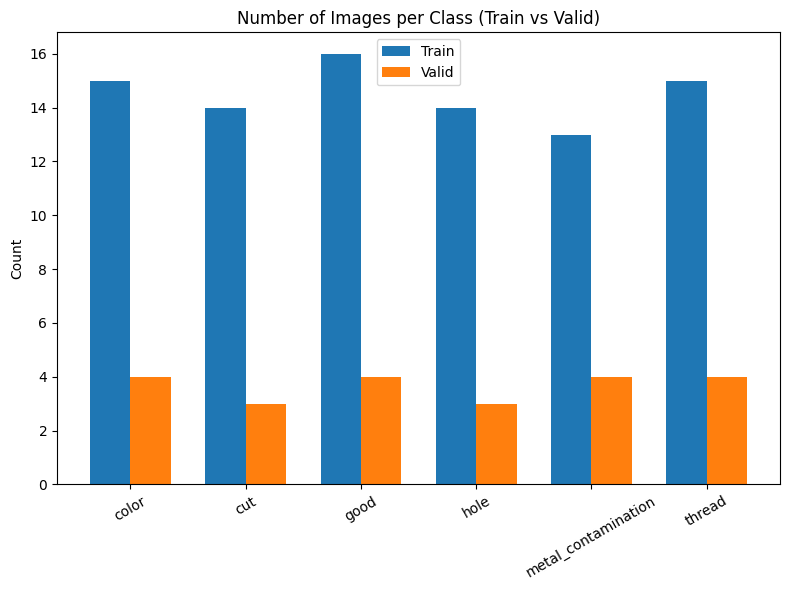

In [300]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# 計算各類別在 train 和 valid 中的數量
label_counts_train = Counter([targets[i] for i in train_idx])
label_counts_valid = Counter([targets[i] for i in valid_idx])

# 所有類別（假設已定義為 classes = ['class0', 'class1', ..., 'classN']）
num_classes = len(classes)
x = np.arange(num_classes)  # x 軸位置

# 取得對應數量，沒有的類別補 0
train_counts = [label_counts_train.get(i, 0) for i in range(num_classes)]
valid_counts = [label_counts_valid.get(i, 0) for i in range(num_classes)]

# 畫圖
bar_width = 0.35
plt.figure(figsize=(8, 6))
plt.bar(x - bar_width/2, train_counts, width=bar_width, label='Train')
plt.bar(x + bar_width/2, valid_counts, width=bar_width, label='Valid')

# x 軸標籤
plt.xticks(x, classes, rotation=30)
plt.ylabel('Count')
plt.title('Number of Images per Class (Train vs Valid)')
plt.legend()

# y 軸顯示整數
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

## B. Defining Neural Networks

In [301]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

model = models.resnet34(weights='IMAGENET1K_V1')

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = 6

# change # of class from 1000 into 8 in the last layer
model.fc = nn.Linear(num_ftrs, num_class)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## C. Training the Neural Network

In [302]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 50
model.to(device)


best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0
    print(f"epoch: {epoch}")

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:

            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 0


  2%|▏         | 1/50 [00:07<05:59,  7.34s/it]

Epoch 1/50, Train loss: 2.2295, Train acc: 17.2414%, Val loss: 2.2284, Val acc: 13.6364%, Best Val loss: 2.2284 Best Val acc: 13.64%
epoch: 1


  4%|▍         | 2/50 [00:14<05:49,  7.28s/it]

Epoch 2/50, Train loss: 1.9502, Train acc: 18.3908%, Val loss: 2.5594, Val acc: 18.1818%, Best Val loss: 2.2284 Best Val acc: 18.18%
epoch: 2


  6%|▌         | 3/50 [00:21<05:39,  7.23s/it]

Epoch 3/50, Train loss: 1.8568, Train acc: 25.2874%, Val loss: 2.7542, Val acc: 13.6364%, Best Val loss: 2.2284 Best Val acc: 18.18%
epoch: 3


  8%|▊         | 4/50 [00:29<05:33,  7.25s/it]

Epoch 4/50, Train loss: 1.6285, Train acc: 27.5862%, Val loss: 2.6380, Val acc: 13.6364%, Best Val loss: 2.2284 Best Val acc: 18.18%
epoch: 4


 10%|█         | 5/50 [00:36<05:27,  7.28s/it]

Epoch 5/50, Train loss: 1.4764, Train acc: 45.9770%, Val loss: 2.9584, Val acc: 18.1818%, Best Val loss: 2.2284 Best Val acc: 18.18%
epoch: 5


 12%|█▏        | 6/50 [00:43<05:21,  7.31s/it]

Epoch 6/50, Train loss: 1.4098, Train acc: 52.8736%, Val loss: 3.4767, Val acc: 13.6364%, Best Val loss: 2.2284 Best Val acc: 18.18%
epoch: 6


 14%|█▍        | 7/50 [00:51<05:14,  7.31s/it]

Epoch 7/50, Train loss: 1.3730, Train acc: 49.4253%, Val loss: 4.0557, Val acc: 18.1818%, Best Val loss: 2.2284 Best Val acc: 18.18%
epoch: 7


 16%|█▌        | 8/50 [00:58<05:06,  7.30s/it]

Epoch 8/50, Train loss: 1.2166, Train acc: 52.8736%, Val loss: 3.9259, Val acc: 13.6364%, Best Val loss: 2.2284 Best Val acc: 18.18%
epoch: 8


 18%|█▊        | 9/50 [01:05<04:57,  7.25s/it]

Epoch 9/50, Train loss: 1.1809, Train acc: 60.9195%, Val loss: 3.4034, Val acc: 13.6364%, Best Val loss: 2.2284 Best Val acc: 18.18%
epoch: 9


 20%|██        | 10/50 [01:12<04:48,  7.21s/it]

Epoch 10/50, Train loss: 1.0860, Train acc: 64.3678%, Val loss: 3.3544, Val acc: 18.1818%, Best Val loss: 2.2284 Best Val acc: 18.18%
epoch: 10


 22%|██▏       | 11/50 [01:19<04:40,  7.19s/it]

Epoch 11/50, Train loss: 1.1211, Train acc: 60.9195%, Val loss: 2.8846, Val acc: 13.6364%, Best Val loss: 2.2284 Best Val acc: 18.18%
epoch: 11


 24%|██▍       | 12/50 [01:26<04:32,  7.18s/it]

Epoch 12/50, Train loss: 0.9780, Train acc: 74.7126%, Val loss: 2.3253, Val acc: 36.3636%, Best Val loss: 2.2284 Best Val acc: 36.36%
epoch: 12


 26%|██▌       | 13/50 [01:34<04:27,  7.22s/it]

Epoch 13/50, Train loss: 0.9577, Train acc: 78.1609%, Val loss: 1.8659, Val acc: 18.1818%, Best Val loss: 1.8659 Best Val acc: 36.36%
epoch: 13


 28%|██▊       | 14/50 [01:41<04:20,  7.24s/it]

Epoch 14/50, Train loss: 0.8831, Train acc: 75.8621%, Val loss: 1.8846, Val acc: 22.7273%, Best Val loss: 1.8659 Best Val acc: 36.36%
epoch: 14


 30%|███       | 15/50 [01:48<04:13,  7.24s/it]

Epoch 15/50, Train loss: 0.9125, Train acc: 79.3103%, Val loss: 1.8467, Val acc: 18.1818%, Best Val loss: 1.8467 Best Val acc: 36.36%
epoch: 15


 32%|███▏      | 16/50 [01:55<04:04,  7.18s/it]

Epoch 16/50, Train loss: 0.8382, Train acc: 81.6092%, Val loss: 2.0222, Val acc: 22.7273%, Best Val loss: 1.8467 Best Val acc: 36.36%
epoch: 16


 34%|███▍      | 17/50 [02:02<03:56,  7.16s/it]

Epoch 17/50, Train loss: 0.7963, Train acc: 83.9080%, Val loss: 2.3287, Val acc: 22.7273%, Best Val loss: 1.8467 Best Val acc: 36.36%
epoch: 17


 36%|███▌      | 18/50 [02:09<03:48,  7.14s/it]

Epoch 18/50, Train loss: 0.7150, Train acc: 87.3563%, Val loss: 2.5239, Val acc: 22.7273%, Best Val loss: 1.8467 Best Val acc: 36.36%
epoch: 18


 38%|███▊      | 19/50 [02:17<03:40,  7.12s/it]

Epoch 19/50, Train loss: 0.7068, Train acc: 80.4598%, Val loss: 2.3836, Val acc: 22.7273%, Best Val loss: 1.8467 Best Val acc: 36.36%
epoch: 19


 40%|████      | 20/50 [02:24<03:32,  7.09s/it]

Epoch 20/50, Train loss: 0.7675, Train acc: 80.4598%, Val loss: 2.4677, Val acc: 31.8182%, Best Val loss: 1.8467 Best Val acc: 36.36%
epoch: 20


 42%|████▏     | 21/50 [02:31<03:25,  7.09s/it]

Epoch 21/50, Train loss: 0.6668, Train acc: 81.6092%, Val loss: 2.8487, Val acc: 31.8182%, Best Val loss: 1.8467 Best Val acc: 36.36%
epoch: 21


 44%|████▍     | 22/50 [02:38<03:20,  7.17s/it]

Epoch 22/50, Train loss: 0.6541, Train acc: 81.6092%, Val loss: 2.9836, Val acc: 40.9091%, Best Val loss: 1.8467 Best Val acc: 40.91%
epoch: 22


 46%|████▌     | 23/50 [02:45<03:15,  7.22s/it]

Epoch 23/50, Train loss: 0.6640, Train acc: 85.0575%, Val loss: 2.4417, Val acc: 45.4545%, Best Val loss: 1.8467 Best Val acc: 45.45%
epoch: 23


 48%|████▊     | 24/50 [02:53<03:08,  7.25s/it]

Epoch 24/50, Train loss: 0.6870, Train acc: 83.9080%, Val loss: 1.8648, Val acc: 50.0000%, Best Val loss: 1.8467 Best Val acc: 50.00%
epoch: 24


 50%|█████     | 25/50 [03:00<03:01,  7.27s/it]

Epoch 25/50, Train loss: 0.5060, Train acc: 91.9540%, Val loss: 1.6016, Val acc: 54.5455%, Best Val loss: 1.6016 Best Val acc: 54.55%
epoch: 25


 52%|█████▏    | 26/50 [03:07<02:55,  7.31s/it]

Epoch 26/50, Train loss: 0.7035, Train acc: 80.4598%, Val loss: 1.3090, Val acc: 68.1818%, Best Val loss: 1.3090 Best Val acc: 68.18%
epoch: 26


 54%|█████▍    | 27/50 [03:15<02:46,  7.25s/it]

Epoch 27/50, Train loss: 0.6032, Train acc: 87.3563%, Val loss: 1.1858, Val acc: 63.6364%, Best Val loss: 1.1858 Best Val acc: 68.18%
epoch: 27


 56%|█████▌    | 28/50 [03:22<02:38,  7.22s/it]

Epoch 28/50, Train loss: 0.5507, Train acc: 87.3563%, Val loss: 1.1157, Val acc: 68.1818%, Best Val loss: 1.1157 Best Val acc: 68.18%
epoch: 28


 58%|█████▊    | 29/50 [03:29<02:31,  7.20s/it]

Epoch 29/50, Train loss: 0.5087, Train acc: 90.8046%, Val loss: 1.0592, Val acc: 72.7273%, Best Val loss: 1.0592 Best Val acc: 72.73%
epoch: 29


 60%|██████    | 30/50 [03:36<02:23,  7.19s/it]

Epoch 30/50, Train loss: 0.5172, Train acc: 94.2529%, Val loss: 1.0019, Val acc: 72.7273%, Best Val loss: 1.0019 Best Val acc: 72.73%
epoch: 30


 62%|██████▏   | 31/50 [03:43<02:16,  7.20s/it]

Epoch 31/50, Train loss: 0.5396, Train acc: 89.6552%, Val loss: 0.9589, Val acc: 77.2727%, Best Val loss: 0.9589 Best Val acc: 77.27%
epoch: 31


 64%|██████▍   | 32/50 [03:50<02:09,  7.22s/it]

Epoch 32/50, Train loss: 0.5843, Train acc: 86.2069%, Val loss: 0.9375, Val acc: 81.8182%, Best Val loss: 0.9375 Best Val acc: 81.82%
epoch: 32


 66%|██████▌   | 33/50 [03:58<02:02,  7.23s/it]

Epoch 33/50, Train loss: 0.4808, Train acc: 91.9540%, Val loss: 0.9402, Val acc: 86.3636%, Best Val loss: 0.9375 Best Val acc: 86.36%
epoch: 33


 68%|██████▊   | 34/50 [04:05<01:55,  7.21s/it]

Epoch 34/50, Train loss: 0.4731, Train acc: 90.8046%, Val loss: 0.9362, Val acc: 86.3636%, Best Val loss: 0.9362 Best Val acc: 86.36%
epoch: 34


 70%|███████   | 35/50 [04:12<01:48,  7.21s/it]

Epoch 35/50, Train loss: 0.5051, Train acc: 90.8046%, Val loss: 0.9992, Val acc: 86.3636%, Best Val loss: 0.9362 Best Val acc: 86.36%
epoch: 35


 72%|███████▏  | 36/50 [04:19<01:40,  7.19s/it]

Epoch 36/50, Train loss: 0.4461, Train acc: 93.1034%, Val loss: 0.9503, Val acc: 81.8182%, Best Val loss: 0.9362 Best Val acc: 86.36%
epoch: 36


 74%|███████▍  | 37/50 [04:26<01:33,  7.16s/it]

Epoch 37/50, Train loss: 0.5514, Train acc: 88.5057%, Val loss: 0.9288, Val acc: 86.3636%, Best Val loss: 0.9288 Best Val acc: 86.36%
epoch: 37


 76%|███████▌  | 38/50 [04:34<01:26,  7.20s/it]

Epoch 38/50, Train loss: 0.5074, Train acc: 88.5057%, Val loss: 0.8827, Val acc: 86.3636%, Best Val loss: 0.8827 Best Val acc: 86.36%
epoch: 38


 78%|███████▊  | 39/50 [04:41<01:19,  7.21s/it]

Epoch 39/50, Train loss: 0.4537, Train acc: 91.9540%, Val loss: 0.8619, Val acc: 86.3636%, Best Val loss: 0.8619 Best Val acc: 86.36%
epoch: 39


 80%|████████  | 40/50 [04:48<01:12,  7.21s/it]

Epoch 40/50, Train loss: 0.4401, Train acc: 93.1034%, Val loss: 0.9084, Val acc: 86.3636%, Best Val loss: 0.8619 Best Val acc: 86.36%
epoch: 40


 82%|████████▏ | 41/50 [04:55<01:04,  7.17s/it]

Epoch 41/50, Train loss: 0.4198, Train acc: 94.2529%, Val loss: 0.9194, Val acc: 86.3636%, Best Val loss: 0.8619 Best Val acc: 86.36%
epoch: 41


 84%|████████▍ | 42/50 [05:02<00:57,  7.14s/it]

Epoch 42/50, Train loss: 0.3999, Train acc: 96.5517%, Val loss: 0.9540, Val acc: 86.3636%, Best Val loss: 0.8619 Best Val acc: 86.36%
epoch: 42


 86%|████████▌ | 43/50 [05:09<00:50,  7.14s/it]

Epoch 43/50, Train loss: 0.3498, Train acc: 96.5517%, Val loss: 0.9801, Val acc: 86.3636%, Best Val loss: 0.8619 Best Val acc: 86.36%
epoch: 43


 88%|████████▊ | 44/50 [05:16<00:42,  7.12s/it]

Epoch 44/50, Train loss: 0.3425, Train acc: 96.5517%, Val loss: 0.9546, Val acc: 86.3636%, Best Val loss: 0.8619 Best Val acc: 86.36%
epoch: 44


 90%|█████████ | 45/50 [05:23<00:35,  7.10s/it]

Epoch 45/50, Train loss: 0.4327, Train acc: 91.9540%, Val loss: 0.9605, Val acc: 86.3636%, Best Val loss: 0.8619 Best Val acc: 86.36%
epoch: 45


 92%|█████████▏| 46/50 [05:31<00:28,  7.12s/it]

Epoch 46/50, Train loss: 0.3522, Train acc: 95.4023%, Val loss: 0.9584, Val acc: 86.3636%, Best Val loss: 0.8619 Best Val acc: 86.36%
epoch: 46


 94%|█████████▍| 47/50 [05:38<00:21,  7.11s/it]

Epoch 47/50, Train loss: 0.3589, Train acc: 97.7011%, Val loss: 0.9592, Val acc: 86.3636%, Best Val loss: 0.8619 Best Val acc: 86.36%
epoch: 47


 96%|█████████▌| 48/50 [05:45<00:14,  7.12s/it]

Epoch 48/50, Train loss: 0.4302, Train acc: 95.4023%, Val loss: 0.9906, Val acc: 81.8182%, Best Val loss: 0.8619 Best Val acc: 86.36%
epoch: 48


 98%|█████████▊| 49/50 [05:52<00:07,  7.12s/it]

Epoch 49/50, Train loss: 0.3905, Train acc: 93.1034%, Val loss: 0.9913, Val acc: 81.8182%, Best Val loss: 0.8619 Best Val acc: 86.36%
epoch: 49


100%|██████████| 50/50 [05:59<00:00,  7.20s/it]

Epoch 50/50, Train loss: 0.3645, Train acc: 94.2529%, Val loss: 0.9496, Val acc: 90.9091%, Best Val loss: 0.8619 Best Val acc: 90.91%


### Visualizing model performance

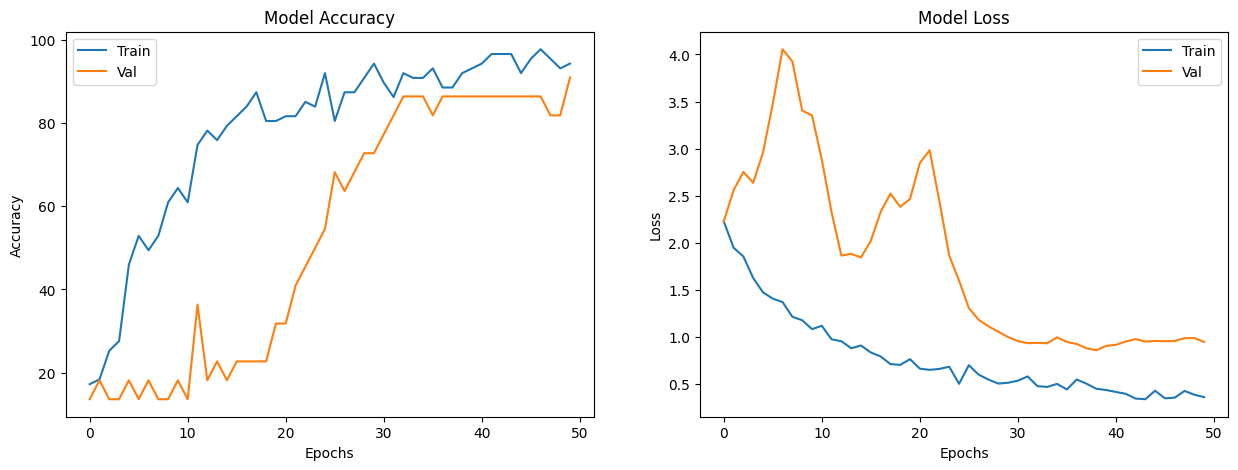

In [303]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [304]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

train_correct = 0
train_total = 0
test_correct = 0
test_total = 0
total_loss_train = 0
total_loss_test = 0

with torch.no_grad():
    
    for images, labels in train_loader:

        images = images.cuda()

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)
        train_loss = criterion(outputs, labels)
        

        predicted = outputs.argmax(-1)
        print("train 預測值:",predicted)
        print("train 實際值:",labels)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
        total_loss_train += train_loss.item()

    avg_train_loss = total_loss_train / len(train_loader)
    train_acc = 100. * train_correct / train_total
    
    for images, labels in val_loader:

        images = images.cuda()

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)
        test_loss = criterion(outputs, labels)


        predicted = outputs.argmax(-1)
        print("test 預測值:",predicted)
        print("test 實際值:",labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)
        total_loss_test += test_loss.item()
    
    avg_test_loss = total_loss_test / len(val_loader)
    test_acc = 100. * test_correct / test_total

print(f'Train loss is {round(avg_train_loss,2)}')
print(f'Test loss is {round(avg_test_loss,2)}')
print(f'Train accuracy is {round(train_acc,2)}%')
print(f'Test accuracy is {round(test_acc,2)}%')

C:\Users\113034507\AppData\Local\Temp\ipykernel_11416\3299945229.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_classification.p

train 預測值: tensor([5, 4, 4, 2, 0, 0, 0, 3, 1, 4, 5, 3, 1, 5, 5, 4, 1, 5, 4, 0, 2, 0, 3, 5,
        1, 3, 2, 2, 4, 3, 1, 1], device='cuda:0')
train 實際值: tensor([5, 4, 4, 2, 0, 0, 0, 3, 1, 4, 5, 3, 1, 5, 5, 4, 1, 5, 4, 0, 2, 0, 3, 5,
        1, 3, 2, 2, 4, 3, 1, 1], device='cuda:0')
train 預測值: tensor([1, 1, 0, 5, 3, 0, 2, 4, 0, 3, 4, 5, 4, 0, 4, 0, 2, 4, 4, 1, 2, 2, 2, 5,
        2, 0, 2, 3, 0, 3, 3, 2], device='cuda:0')
train 實際值: tensor([1, 1, 0, 5, 3, 0, 2, 4, 0, 3, 4, 5, 4, 0, 4, 0, 2, 4, 4, 1, 2, 2, 2, 5,
        2, 0, 2, 3, 0, 3, 3, 2], device='cuda:0')
train 預測值: tensor([5, 4, 5, 1, 0, 5, 2, 3, 3, 5, 1, 1, 2, 2, 1, 3, 5, 0, 3, 1, 5, 2, 0],
       device='cuda:0')
train 實際值: tensor([5, 4, 5, 1, 0, 5, 2, 3, 3, 5, 1, 1, 2, 2, 1, 3, 5, 0, 3, 1, 5, 2, 0],
       device='cuda:0')
test 預測值: tensor([5, 2, 0, 4, 2, 0, 2, 4, 3, 1, 3, 5, 1, 0, 1, 4, 2, 3, 2, 0, 5, 5],
       device='cuda:0')
test 實際值: tensor([0, 2, 2, 4, 2, 0, 2, 4, 3, 1, 3, 5, 1, 0, 1, 4, 2, 3, 2, 0, 5, 5],
       device='c